In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

## Load all data:

In [5]:
from utils.format_data import load_json_files_from_folder, aggregate_stories_with_years_before_diagnostic
# import healty aging data
healthy_dir = "../../stories/data_oct_6/healthyAging"
healthy_data = load_json_files_from_folder(healthy_dir)
healthy_agg_data = aggregate_stories_with_years_before_diagnostic(healthy_data)

# import dementia data
dementia_dir = "../../stories/data_oct_10/dementia"
dementia_data = load_json_files_from_folder(dementia_dir)
dementia_agg_data = aggregate_stories_with_years_before_diagnostic(
    dementia_data)

all_data = [dementia_agg_data, healthy_agg_data]

Loaded: mark-edward-thompson.json - Character: Mark Edward Thompson - Start deterioration age: 69
Loaded: olivia-margaret-chen.json - Character: Olivia Margaret Chen - Start deterioration age: 72
Loaded: lisa-carmen-alvarez.json - Character: Lisa Carmen Alvarez - Start deterioration age: 69
Loaded: jessica-marie-holloway.json - Character: Jessica Marie Holloway - Start deterioration age: 75
Loaded: keren-aliza-hadar.json - Character: Keren Aliza Hadar - Start deterioration age: 72
Loaded: jacob-stein.json - Character: Jacob Stein - Start deterioration age: 69
Loaded: robert-elias-garner.json - Character: Robert Elias Garner - Start deterioration age: 72
Loaded: anthony-samuel-reyes.json - Character: Anthony Samuel Reyes - Start deterioration age: 72
Loaded: george-leonard.json - Character: George Leonard - Start deterioration age: 75
Loaded: james-whitaker.json - Character: James Whitaker - Start deterioration age: 72
Loaded: mark-edward-thompson.json - Character: Mark Edward Thompson 

In [6]:
import numpy as np
from scipy import stats
from utils.extract_nlp_features import (
    nouns_freq_in_text,
    word_used_once_frequency,
    word_used_once_or_twice_frequency,
    brunet_index,
    token_type_ratio,
    adposition_frequency,
    uni_and_bi_grams_repetitions,
    word_freq_subtl,
    word_freq_zipf
)

In [7]:
# Load word frequency data
try:
    subtl_and_zipf_df = pd.read_csv('../../subtl_and_zipf.csv')
    subtl_and_zipf_df = subtl_and_zipf_df[[
        'Word', 'FREQcount', 'SUBTLWF', 'Zipf-value']]
    print("Successfully loaded word frequency data.")
except FileNotFoundError:
    print("Warning: subtl_and_zipf.csv not found. Skipping frequency analysis.")
    subtl_and_zipf_df = None

Successfully loaded word frequency data.


In [ ]:
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std if pooled_std > 0 else 0


def create_comprehensive_multi_group_scatter_plot(data_groups, group_names=None):
    """
    Create a comprehensive 3x3 subplot showing all linguistic metrics as scatter plots
    for multiple groups with different colors and trend lines for each group.
    Displays t-test results between groups instead of correlation.

    Parameters:
    -----------
    data_groups : list of lists
        List where each element is a story data list (from aggregate_stories_with_years_before_diagnostic)
    group_names : list of str, optional
        Names for each group (e.g., ['Healthy Aging', 'Dementia'])
        If None, will use 'Group 1', 'Group 2', etc.
    """
    if group_names is None:
        group_names = [f'Group {i+1}' for i in range(len(data_groups))]

    # Prepare the metric functions
    metric_functions = [
        (nouns_freq_in_text, "Noun Token Ratio", "Ratio"),
        (word_used_once_frequency, "Hapax Legomena", "Ratio"),
        (word_used_once_or_twice_frequency, "Low-Frequency (≤2) Ratio", "Ratio"),
        (brunet_index, "Brunet Index", "Index"),
        (token_type_ratio, "Type-Token Ratio", "Ratio"),
        (adposition_frequency, "Adposition Ratio", "Ratio"),
        (uni_and_bi_grams_repetitions, "Repetition Ratio (Uni+Bi)", "Ratio"),
    ]

    # Add frequency metrics if available
    if subtl_and_zipf_df is not None:
        def zipf_metric(text):
            return word_freq_zipf(text, subtl_and_zipf_df)

        def subtl_metric(text):
            return word_freq_subtl(text, subtl_and_zipf_df)

        metric_functions.insert(
            6, (subtl_metric, "SUBTLEX Frequency", "Mean Weighted"))
        metric_functions.insert(
            6, (zipf_metric, "Zipf Frequency", "Mean Weighted"))

    fig, axes = plt.subplots(3, 3, figsize=(16, 12))
    fig.suptitle('Linguistic Analysis: Control vs Dementia',
                 fontsize=16, fontweight='bold')

    # Define colors for each group
    group_colors = ["#ff0e0e", "#0f9c9c", '#2ca02c', '#d62728', '#9467bd',
                    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    for i, (metric_function, title, ylabel) in enumerate(metric_functions):
        row = i // 3
        col = i % 3
        ax = axes[row, col]

        # Collect metrics for each group for t-test
        group_metrics = []

        # Process each group
        for group_idx, (story_data, group_name) in enumerate(zip(data_groups, group_names)):
            x_values = []
            y_values = []
            # add background color to all subplots
            ax.set_facecolor("#FCFCFC")

            for story_point in story_data:
                try:
                    metric_value = metric_function(story_point['story'])
                    x_values.append(story_point['years_before_diagnostic'])
                    y_values.append(metric_value)
                except Exception:
                    continue

            group_metrics.append(y_values)

            if x_values:
                # Scatter plot for this group
                ax.scatter(x_values, y_values, alpha=0.5, s=40,
                           color=group_colors[group_idx % len(group_colors)],
                           label=group_name, edgecolors='black', linewidth=0.3)

                # Add trend line for this group
                if len(x_values) > 1:
                    try:
                        z = np.polyfit(x_values, y_values, 1)
                        p = np.poly1d(z)
                        x_trend = np.linspace(
                            min(x_values), max(x_values), 100)
                        ax.plot(x_trend, p(x_trend),
                                color=group_colors[group_idx %
                                                   len(group_colors)],
                                linestyle='-', alpha=0.8, linewidth=1.5)
                    except Exception:
                        pass

        # Perform t-test between groups
        if len(group_metrics) >= 2 and all(len(g) > 1 for g in group_metrics[:2]):
            try:
                t_stat, p_val = stats.ttest_ind(
                    group_metrics[0], group_metrics[1])
                d = cohens_d(group_metrics[0], group_metrics[1])

                sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                ax.text(0.02, 0.98, f't={t_stat:.3f} ({sig})\np={p_val:.3g}\nd={d:.3f}',
                        transform=ax.transAxes, fontsize=8,
                        verticalalignment='top',
                        bbox=dict(boxstyle="round,pa0.2", facecolor="white", alpha=0.7))
            except Exception:
                pass

        # Calculate overall x range
        all_x = []
        for story_data in data_groups:
            for story_point in story_data:
                try:
                    all_x.append(story_point['years_before_diagnostic'])
                except Exception:
                    continue

        ax.set_xlabel('Years Before Diagnostic', fontsize=9)
        ax.set_ylabel(ylabel, fontsize=9)
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=8)

        if all_x:
            ax.set_xticks(np.arange(-15, max(all_x)+1, 3))
            ax.set_xlim(left=-16)

        if not all_x:
            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center',
                    transform=ax.transAxes, fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

    # Add legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.02, 0.98),
                   title='Groups', title_fontsize=10, fontsize=8)

    plt.tight_layout(rect=[0, 0.03, 0.85, 0.95])
    plt.show()

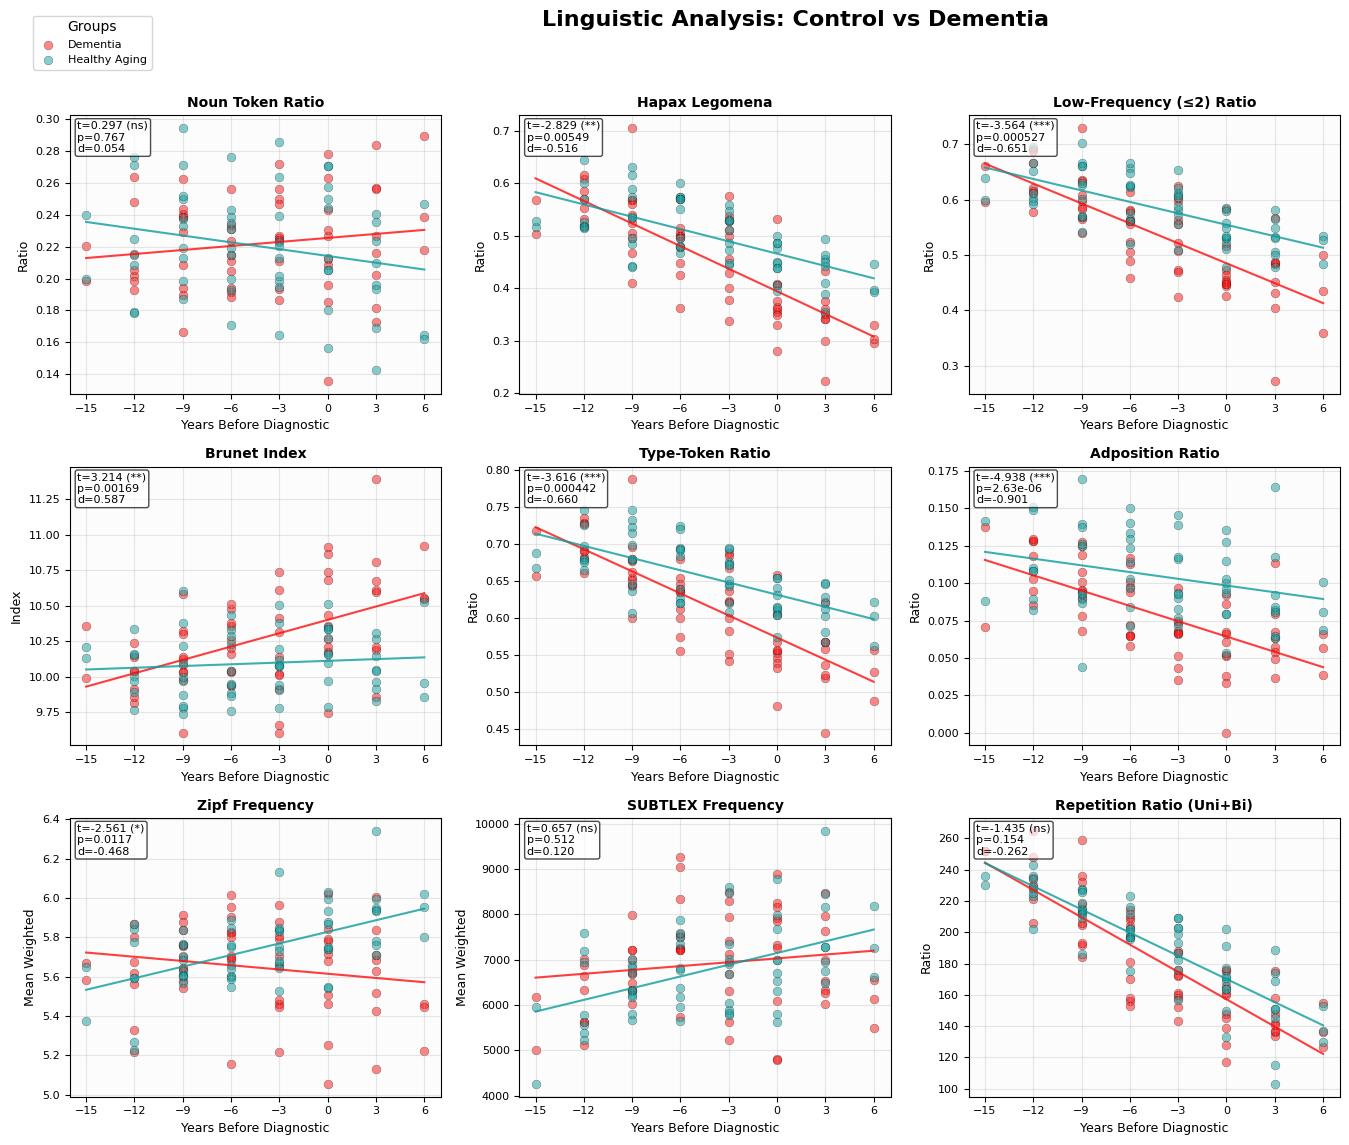

In [9]:
# Create comprehensive multi-group scatter plot
create_comprehensive_multi_group_scatter_plot(
    all_data,
    group_names=['Dementia', 'Healthy Aging']
)

In [ ]:
# Summary Table: T-Test Results

# Collect all t-test results
metric_functions = [
    (nouns_freq_in_text, "Noun Token Ratio", "Ratio"),
    (word_used_once_frequency, "Hapax Legomena", "Ratio"),
    (word_used_once_or_twice_frequency, "Low-Frequency (≤2) Ratio", "Ratio"),
    (brunet_index, "Brunet Index", "Index"),
    (token_type_ratio, "Type-Token Ratio", "Ratio"),
    (adposition_frequency, "Adposition Ratio", "Ratio"),
    (uni_and_bi_grams_repetitions, "Repetition Ratio (Uni+Bi)", "Ratio"),
]

if subtl_and_zipf_df is not None:
    def zipf_metric(text):
        return word_freq_zipf(text, subtl_and_zipf_df)

    def subtl_metric(text):
        return word_freq_subtl(text, subtl_and_zipf_df)

    metric_functions.insert(
        6, (subtl_metric, "SUBTLEX Frequency", "Mean Weighted"))
    metric_functions.insert(
        6, (zipf_metric, "Zipf Frequency", "Mean Weighted"))

results = []

for metric_function, title, ylabel in metric_functions:
    dementia_values = []
    healthy_values = []

    # Extract metrics from dementia group
    for story_point in all_data[0]:
        try:
            metric_value = metric_function(story_point['story'])
            dementia_values.append(metric_value)
        except Exception:
            continue

    # Extract metrics from healthy group
    for story_point in all_data[1]:
        try:
            metric_value = metric_function(story_point['story'])
            healthy_values.append(metric_value)
        except Exception:
            continue

    if len(dementia_values) > 1 and len(healthy_values) > 1:
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(dementia_values, healthy_values)
        d = cohens_d(dementia_values, healthy_values)

        # Determine significance
        if p_val < 0.001:
            sig = "***"
        elif p_val < 0.01:
            sig = "**"
        elif p_val < 0.05:
            sig = "*"
        else:
            sig = "ns"

        results.append({
            'Feature': title,
            'Dementia Mean': f"{np.mean(dementia_values):.4f}",
            'Healthy Mean': f"{np.mean(healthy_values):.4f}",
            'Mean Diff': f"{np.mean(dementia_values) - np.mean(healthy_values):.4f}",
            't-statistic': f"{t_stat:.4f}",
            'p-value': f"{p_val:.4g}",
            'Significance': sig,
            "Cohen's d": f"{d:.4f}"
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(
    'p-value', key=lambda x: x.str.replace('ns', '1').astype(float))

print("\n" + "="*140)
print("T-TEST RESULTS: DEMENTIA vs HEALTHY AGING GROUPS")
print("="*140)
print(results_df.to_string(index=False))
print("\nSignificance codes: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("="*140 + "\n")

# Count significant features
sig_count = len(results_df[results_df['Significance'] != 'ns'])
print(
    f"✓ Significant features (p < 0.05): {sig_count} out of {len(results_df)}")
print(
    f"✓ Non-significant features: {len(results_df) - sig_count} out of {len(results_df)}")


T-TEST RESULTS: DEMENTIA vs HEALTHY AGING GROUPS
                  Feature Dementia Mean Healthy Mean Mean Diff t-statistic   p-value Significance Cohen's d
         Adposition Ratio        0.0787       0.1047   -0.0261     -4.9376 2.629e-06          ***   -0.9015
         Type-Token Ratio        0.6148       0.6541   -0.0393     -3.6159 0.0004415          ***   -0.6602
 Low-Frequency (≤2) Ratio        0.5355       0.5836   -0.0480     -3.5644 0.0005275          ***   -0.6508
             Brunet Index       10.2679      10.0935    0.1743      3.2136  0.001691           **    0.5867
           Hapax Legomena        0.4540       0.4983   -0.0443     -2.8289   0.00549           **   -0.5165
           Zipf Frequency        5.6453       5.7455   -0.1002     -2.5611    0.0117            *   -0.4676
Repetition Ratio (Uni+Bi)      181.6667     190.9167   -9.2500     -1.4354    0.1538           ns   -0.2621
        SUBTLEX Frequency     6909.3109    6785.2149  124.0959      0.6570    0.5125  